# Data Processing

In [ ]:
import csv

In [2]:
with open("data/password_trainv3.csv") as csv_file:
    reader = csv.reader(csv_file)
    char_ststistics = {}
    for i, row in enumerate(reader):
        if(i == 0): continue
        for c in row[1]:
            if c in char_ststistics: char_ststistics[c] += 1
            else: char_ststistics[c] = 1

In [3]:
values = []
alphapet = ''
for c in sorted(char_ststistics):
    print(c, char_ststistics[c])
    values.append(char_ststistics[c])
    alphapet += c

print(f'min value {min(values)}\nmax value {max(values)}')
print(len(alphapet))
print (alphapet)

! 66
" 72
# 114
$ 99
% 66
& 63
' 84
( 54
) 66
* 96
+ 54
, 72
- 84
. 81
/ 57
0 114
1 120
2 114
3 105
4 138
5 111
6 114
7 99
8 90
9 105
: 57
; 69
< 75
= 84
> 72
? 66
@ 60
A 54
B 78
C 84
D 75
E 84
F 69
G 84
H 54
I 87
J 78
K 39
L 72
M 69
N 78
O 75
P 75
Q 66
R 81
S 81
T 99
U 42
V 69
W 96
X 75
Y 69
Z 72
[ 60
\ 63
] 87
^ 84
_ 54
` 81
a 93
b 69
c 63
d 96
e 60
f 72
g 87
h 87
i 81
j 66
k 66
l 45
m 111
n 114
o 63
p 72
q 69
r 69
s 48
t 69
u 60
v 63
w 81
x 60
y 66
z 63
{ 57
| 63
} 81
~ 60
min value 39
max value 138
94
!"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]^_`abcdefghijklmnopqrstuvwxyz{|}~


# DataSet.py

In [4]:
from torch.utils.data import Dataset, sampler, DataLoader
import torch
import torch.nn.functional as F
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt
import csv
from PIL import Image
import random

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
class Passwords_data(Dataset):
    def __init__ (self, csv_Path, imgs_path, transformers = None):
        with open(csv_Path, 'r') as csv_file:
            # images names and labels in matching indices
            reader = csv.reader(csv_file)
            self.imgs = []
            self.lables = []
            for i, row in enumerate(reader):
                if i == 0: continue
                self.imgs.append(row[0])
                self.lables.append(row[1])
                
            self.imgs_file = imgs_path
            self.transformers = transformers
    
    def __getitem__(self, index):
        # image
        img_path = self.imgs_file + '/' + self.imgs[index]
        img = Image.open(img_path).convert('L')
        #print(img.size)
        
        # image augmentation
        if self.transformers != None:
            img = self.transformers(img)
        img = transforms.ToTensor()(img)
        # lable
        lable = self.lables[index]
        
        return (img_path, img, lable)
    
    def __len__(self):
        return len(self.imgs)

In [6]:
class ResizeNormalize (object):
    def __init__(self, img_size):
        self.img_size = img_size # imgH, imgW
    
    def __call__(self, img):
        img = transforms.Resize(size=self.img_size)(transforms.ToPILImage()(img))
        img = transforms.ToTensor()(img)
        img.sub_(0.5).div_(0.5) # normalize gray scale
        return img

In [7]:
class AlignBatch(object):
    def __init__(self, imgH = 32, imgW = 100, keep_ratio = True, min_ratio = 1, padding = False):
        self.imgH = imgH
        self.imgW = imgW
        self.keep_ratio = keep_ratio
        self.min_ratio = min_ratio
        self.padding = padding
        
    def __call__(self, batch):
        img_paths, imgs, lables = zip(*batch)
        imgH = self.imgH
        imgW = self.imgW
        
        if(self.keep_ratio):
            max_ratio = 0
            for img in imgs:
                #print(img.shape)
                _, h, w = img.shape
                if max_ratio < (w/h): max_ratio = (w/h)
            if self.padding:
                imgs_padded = []
                for i, img in enumerate(imgs):
                    _, h, w = img.shape
                    w_new = h * max_ratio
                    pad = int((w_new - w) / 2)
                    #print(img.shape)
                    imgs_padded.append(F.pad(img, (pad, pad), "constant"))
                imgs = imgs_padded
            
            imgW = int(max_ratio * imgH)
            
        resizer = ResizeNormalize((imgH, imgW))
        imgs = [resizer(img).unsqueeze(0) for img in imgs]
        imgs = torch.cat(imgs, 0)
        return img_paths, imgs, lables
                    

In [8]:
class MatchingSampler(sampler.Sampler):
    
    def __init__ (self, data_source, batch_size):
        self.data_source = data_source
        self.number_sampels = len(data_source)
        self.batch_size = batch_size
        
    def __iter__ (self):
        n_batches = len(self)//self.batch_size
        tail = len(self) % self.batch_size
        index = torch.LongTensor(len(self)).fill_(0)
        for i in range(n_batches):
            random_start = random.randint(0, len(self)-self.batch_size)
            b_indx = random_start + torch.arange(0, self.batch_size)
            index[i*self.batch_size : (i+1) * self.batch_size] = b_indx
        if tail:
            random_start = random.randint(0, len(self)-tail)
            b_indx = random_start + torch.arange(0, tail-1)
            index[n_batches * self.batch_size:] = b_indx
            
        return iter(index)
        
    def __len__(self):
        return self.number_sampels

torch.Size([1, 32, 228])


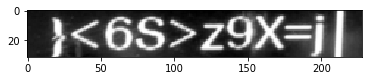

}<6S>z9X=j|
torch.Size([1, 32, 228])


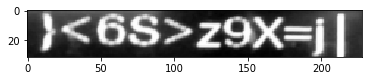

}<6S>z9X=j|
torch.Size([1, 32, 228])


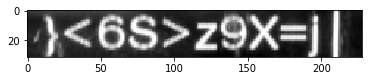

}<6S>z9X=j|
torch.Size([1, 32, 228])


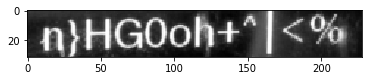

n}HG0oh+^|<%


In [9]:
# test dataset output

dataset = Passwords_data('data/password_trainv3.csv', 'data/train_passwordv3')

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= False)

img_pathes, imgs, lables = next(iter(dataloder))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

# Model

In [10]:
import torch.nn as nn

In [11]:
class BiDrictionalLSTM(nn.Module):
    def __init__(self, nIn, nHidden, nOut):
        super(BiDrictionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)
    
    def forward(self, input):
        recurrent, _ = self.rnn(input)
        t_steps, b_size, h_num = recurrent.shape
        recurrent = recurrent.view(t_steps*b_size, h_num) # prepare the linear layer input
        
        output = self.embedding(recurrent)
        output = output.view(t_steps, b_size, -1)
        
        return output

In [ ]:
'''
class ConvLayer(nn.Module):
    def __init__(self, inFilt, outFilt, kerSiz, padSiz, strideSiz, b_n = False):
        super(ConvLayer, self).__init__()
        self.conv = nn.Conv2d(inFilt, outFilt, kerSiz, padSiz, strideSiz)
        self.relu = nn.ReLU(inplace=True)
    
    def
'''

In [12]:
class CRNN(nn.Module):
    def __init__(self, imgH, inChannal, nClasses, nHidden, nLSTMs = 2):
        super(CRNN, self).__init__()
        assert imgH == 32 , 'the image input hight must be 32'
        
        ks = [3, 3, 3, 3, 3, 3, 2] # kernal Size
        ps = [1, 1, 1, 1, 1, 1, 0] # padding
        ss = [1, 1, 1, 1, 1, 1, 1] # stride
        fn = [64, 128, 256, 256, 512, 512, 512] # filters number
        
        cnn = nn.Sequential()
        
        
        def conv_layer(layNum, b_n = False):
            nIn = inChannal if layNum == 0 else fn[layNum-1]
            nOut = fn[layNum]
            # Conv Layer
            cnn.add_module(f'conv{layNum}', nn.Conv2d(nIn, nOut, ks[layNum], ss[layNum], ps[layNum]))
            # btach normalization
            if b_n:
                cnn.add_module(f'batchnorm{layNum}', nn.BatchNorm2d(nOut))
            # non Linearity (ReLU)
            cnn.add_module(f'relu{layNum}', nn.ReLU(inplace=True))
            
        # Cnn Arch
        conv_layer(0)
        cnn.add_module(f'pooling{0}', nn.MaxPool2d(2, 2))  # 64 x 16
        conv_layer(1)
        cnn.add_module(f'pooling{1}', nn.MaxPool2d(2, 2))  # 128 x 8
        conv_layer(2, b_n=True)
        conv_layer(3)
        # the irregular shape of stride and padding beacause of the shape of some char like (i, ..)
        cnn.add_module(f'pooling{2}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 256 x 4
        conv_layer(4, b_n=True)
        conv_layer(5)
        cnn.add_module(f'pooling{3}', nn.MaxPool2d((2, 2), (2, 1), (0, 1))) # 512 x 2
        conv_layer(6, b_n=True) #  512 x 1

        self.cnn = cnn

        # Rnn Arch
        rnn = nn.Sequential(
            BiDrictionalLSTM(512, nHidden, nHidden),
            BiDrictionalLSTM(nHidden, nHidden, nClasses)
        )

        self.rnn = rnn
        
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input):
        # cnn pass
        conv = self.cnn(input)
        b, c, h, w = conv.shape
        
        assert h == 1, 'the hight after cnn must equal 1'
        
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1) # sequance, batch, features
        
        # rnn pass 
        rnn = self.rnn(conv)
        
        output = self.softmax(rnn)
        
        return output


In [13]:
crnn = CRNN(32, 1, 37, 256)

In [14]:
crnn.load_state_dict(torch.load('weights/crnn.pth'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [15]:
# model state dict
st = crnn.state_dict()
for name in st:
    print(name)

cnn.conv0.weight
cnn.conv0.bias
cnn.conv1.weight
cnn.conv1.bias
cnn.conv2.weight
cnn.conv2.bias
cnn.batchnorm2.weight
cnn.batchnorm2.bias
cnn.batchnorm2.running_mean
cnn.batchnorm2.running_var
cnn.batchnorm2.num_batches_tracked
cnn.conv3.weight
cnn.conv3.bias
cnn.conv4.weight
cnn.conv4.bias
cnn.batchnorm4.weight
cnn.batchnorm4.bias
cnn.batchnorm4.running_mean
cnn.batchnorm4.running_var
cnn.batchnorm4.num_batches_tracked
cnn.conv5.weight
cnn.conv5.bias
cnn.conv6.weight
cnn.conv6.bias
cnn.batchnorm6.weight
cnn.batchnorm6.bias
cnn.batchnorm6.running_mean
cnn.batchnorm6.running_var
cnn.batchnorm6.num_batches_tracked
rnn.0.rnn.weight_ih_l0
rnn.0.rnn.weight_hh_l0
rnn.0.rnn.bias_ih_l0
rnn.0.rnn.bias_hh_l0
rnn.0.rnn.weight_ih_l0_reverse
rnn.0.rnn.weight_hh_l0_reverse
rnn.0.rnn.bias_ih_l0_reverse
rnn.0.rnn.bias_hh_l0_reverse
rnn.0.embedding.weight
rnn.0.embedding.bias
rnn.1.rnn.weight_ih_l0
rnn.1.rnn.weight_hh_l0
rnn.1.rnn.bias_ih_l0
rnn.1.rnn.bias_hh_l0
rnn.1.rnn.weight_ih_l0_reverse
rnn.1.rnn

In [16]:
# checkpoint state dic
st = torch.load('weights/crnn.pth')
for name,k in st.items():
    print(name)

cnn.conv0.weight
cnn.conv0.bias
cnn.conv1.weight
cnn.conv1.bias
cnn.conv2.weight
cnn.conv2.bias
cnn.batchnorm2.weight
cnn.batchnorm2.bias
cnn.batchnorm2.running_mean
cnn.batchnorm2.running_var
cnn.conv3.weight
cnn.conv3.bias
cnn.conv4.weight
cnn.conv4.bias
cnn.batchnorm4.weight
cnn.batchnorm4.bias
cnn.batchnorm4.running_mean
cnn.batchnorm4.running_var
cnn.conv5.weight
cnn.conv5.bias
cnn.conv6.weight
cnn.conv6.bias
cnn.batchnorm6.weight
cnn.batchnorm6.bias
cnn.batchnorm6.running_mean
cnn.batchnorm6.running_var
rnn.0.rnn.weight_ih_l0
rnn.0.rnn.weight_hh_l0
rnn.0.rnn.bias_ih_l0
rnn.0.rnn.bias_hh_l0
rnn.0.rnn.weight_ih_l0_reverse
rnn.0.rnn.weight_hh_l0_reverse
rnn.0.rnn.bias_ih_l0_reverse
rnn.0.rnn.bias_hh_l0_reverse
rnn.0.embedding.weight
rnn.0.embedding.bias
rnn.1.rnn.weight_ih_l0
rnn.1.rnn.weight_hh_l0
rnn.1.rnn.bias_ih_l0
rnn.1.rnn.bias_hh_l0
rnn.1.rnn.weight_ih_l0_reverse
rnn.1.rnn.weight_hh_l0_reverse
rnn.1.rnn.bias_ih_l0_reverse
rnn.1.rnn.bias_hh_l0_reverse
rnn.1.embedding.weight
rn

# Utilties

## Logger

In [17]:
import tensorflow as tf


class Logger(object):
    def __init__(self, log_dir):
        """Create a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def scalar_summary(self, tag, value, step):
        """Log a scalar variable."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value)])
        self.writer.add_summary(summary, step)

    def list_of_scalars_summary(self, tag_value_pairs, step):
        """Log scalar variables."""
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, simple_value=value) for tag, value in tag_value_pairs])
        self.writer.add_summary(summary, step)

## Label String Convertion

In [18]:
class strLabelConverter(object):
    """Convert between str and label.

    NOTE:
        Insert `blank` to the alphabet for CTC.

    Args:
        alphabet (str): set of the possible characters.
        ignore_case (bool, default=True): whether or not to ignore all of the case.
    """

    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index

        self.dict = {}
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1

    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str):
            text = [
                self.dict[char.lower() if self._ignore_case else char]
                for char in text
            ]
            length = [len(text)]
        elif isinstance(text, collections.abc.Iterable):
            length = [len(s) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return ''.join([self.alphabet[i - 1] for i in t]), [i - 1 for i in t]
            else:
                char_list = []
                lables_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                        lables_list.append(t[i] - 1)
                return ''.join(char_list), lables_list
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            lables = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                text, lable = self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw)
                texts.append(text)
                lables.append(lable)
                index += l
            return texts, lables

# Training

In [19]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision
import PIL
import time
import collections

import os

In [20]:
os.makedirs('checkpoints', exist_ok=True)

## Test Tranforms

In [ ]:
train_transforms = transforms.Compose([transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, translate=(.03,.03))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, scale=(.95,1.05))])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomAffine(degrees=0, shear=20)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomRotation(degrees=3, expand=True), 
                                       transforms.ColorJitter(brightness=.5, contrast=.5, saturation=.5)])

In [ ]:
train_transforms = transforms.Compose([transforms.RandomPerspective()])

In [21]:
# final transforms
train_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=0, translate=(.03,.03)),
            transforms.RandomAffine(degrees=0, scale=(.95,1.05)),
            transforms.RandomAffine(degrees=0, shear=20),
            transforms.RandomRotation(degrees=3, expand=True)]),
        transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3)],  p=0.5)])

torch.Size([1, 32, 262])


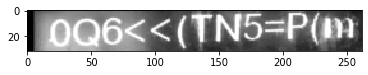

0Q6<<(TN5=P(m
torch.Size([1, 32, 262])


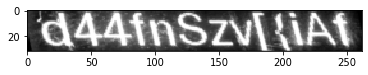

d44fnSzv[{iAf
torch.Size([1, 32, 262])


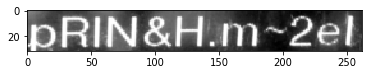

pRIN&H.m~2eI
torch.Size([1, 32, 262])


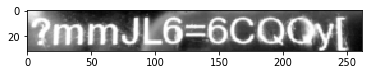

?mmJL6=6CQQy[


In [24]:
dataset = Passwords_data('data/password_trainv3.csv', 'data/train_passwordv3', transformers=train_transforms)

sampler = MatchingSampler(dataset, 4)
align = AlignBatch()
dataloder = DataLoader(dataset, batch_size=4, collate_fn=align, shuffle= True)

img_pathes, imgs, lables = next(iter(dataloder))
#print(converter.encode(lables))

for sample in zip(img_pathes, imgs, lables):
    #print(sample)
    img_path, img, lable = sample
    print(img.shape)
    plt.imshow(img.squeeze(0).numpy(), cmap='gray')
    plt.show()
    print(lable)

## continue training

In [25]:
# training variables 
epochs_num = 100
batch_size = 16
cuda = torch.cuda.is_available()
n_workers = 4
nClasses = len(char_ststistics) + 1
inChannels = 1
imgH = 32
nHidden = 256
lr = .001
test_display = 4
val_each = 1
use_pretrained = True
pre_trained = 'weights/crnn.pth'
fixed_seed = 12
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'detect cuda device? {cuda}')
print(f'number of classes id {nClasses-1} + blank')

detect cuda device? True
number of classes id 94 + blank


In [26]:
# fix seeds
random.seed(fixed_seed)
np.random.seed(fixed_seed)
torch.manual_seed(fixed_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [27]:
train_transforms = transforms.Compose([
    transforms.RandomApply([
        transforms.RandomChoice([
            transforms.RandomAffine(degrees=0, translate=(.03,.03)),
            transforms.RandomAffine(degrees=0, scale=(.95,1.05)),
            transforms.RandomAffine(degrees=0, shear=20),
            transforms.RandomRotation(degrees=3, expand=True)]),
        transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3)],  p=0.5)])

In [28]:
train_dataset = Passwords_data('data/password_train.csv', 'data/train_passwordv3', transformers=train_transforms)

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
train_dataloder = DataLoader(train_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= True, num_workers=n_workers)

In [29]:
val_dataset = Passwords_data('data/password_val.csv', 'data/train_passwordv3')

#sampler = MatchingSampler(dataset, batch_size)
align = AlignBatch()
val_dataloder = DataLoader(val_dataset, batch_size=batch_size, collate_fn=align, 
                       shuffle= False, num_workers=n_workers)

In [30]:
converter = strLabelConverter(alphapet, ignore_case=False)
criterion = nn.CTCLoss()

In [31]:
def weights_init(m):
    class_name = m.__class__.__name__
    if class_name.find('conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif class_name.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [32]:
crnn = CRNN(imgH, inChannels, nClasses, nHidden)
crnn.apply(weights_init)
if use_pretrained :
    model_dict = crnn.state_dict() # state of the current model
    pretrained_dict = torch.load(pre_trained) # state of the pretrained model
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k != 'rnn.1.embedding.weight' and k != 'rnn.1.embedding.bias'} # remove the classifier from the state
    classifier_dict = {k: v for k, v in model_dict.items() if k == 'rnn.1.embedding.weight' or k == 'rnn.1.embedding.bias'} # get the classifier weight from new model
    pretrained_dict.update(classifier_dict) # update without classifier
    crnn.load_state_dict(pretrained_dict)
    
print(crnn)

CRNN(
  (cnn): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu0): ReLU(inplace)
    (pooling0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace)
    (pooling1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace)
    (conv3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace)
    (pooling2): MaxPool2d(kernel_size=(2, 2), stride=(2, 1), padding=(0, 1), dilation=1, ceil_mode=False)
    (conv4): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (batchnorm4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, trac

In [33]:
if cuda :
    crnn = crnn.to(device)
    criterion = criterion.to(device)

In [34]:
optimizer = optim.Adam(crnn.parameters(), lr=lr)
#lr_sheduler = optim.lr_scheduler.StepLR(optimizer, 100, gamma=.5)

In [35]:
# define logger file
os.makedirs('logs', exist_ok=True)
logger = Logger('logs')

In [36]:
# train the model for one epoch
def train(model, criterion, optimizer, logger, train_dataloder, batch_size, epoch_num):
    
    model.train()

    epoch_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(train_dataloder):
        batches_done = len(train_dataloder) * epoch_num + batch_i
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device))
        targets, lenghts = converter.encode(targets)
        targets = Variable(targets.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        # pass to the network
        preds = model(imgs)
        preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))
        
        # loss
        #print(preds_size.shape)
        loss = criterion(preds, targets.cpu(), preds_size, t_lens)
        epoch_loss += loss * imgs.shape[0]
        logger.scalar_summary('loss_batches', loss, batches_done)
        print(f'Epoch {epoch_num}, Batch {batch_i}/{len(train_dataloder)} : Loss = {loss}')
        
        # optimize
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    # compute epoch loss
    epoch_loss /= samples_num
    logger.scalar_summary('loss_epochs', epoch_loss, epoch_num)
    
    return epoch_loss

In [37]:
# compute model accuracy
def val(model, criterion, logger, val_dataloder, epoch_num, batch_size=16, test_display=4, log_name='val'):
    
    model.eval()
    
    nCorrect_words = 0
    val_loss = 0
    samples_num = 0
    
    for batch_i, (_, imgs, targets) in enumerate(val_dataloder):
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device), requires_grad=False)
        targets_encoded, lenghts = converter.encode(targets)
        targets_encoded = Variable(targets_encoded.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        with torch.no_grad():
            # pass to the network
            preds = model(imgs)
            preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))

            # loss
            loss = criterion(preds, targets_encoded.cpu(), preds_size, t_lens)
            val_loss += loss * imgs.shape[0]
            
            # get the nework prediction
            _, preds = preds.max(2)
            preds = preds.transpose(1,0).contiguous().view(-1)
            words_preds, lables_preds = converter.decode(preds, preds_size)
            
            for word_pred, target in zip(words_preds, targets):
                if word_pred == target:
                    nCorrect_words += 1
    
    # display some of the network prediction
    row_preds, _ = converter.decode(preds, preds_size, raw=True)[:test_display]

    for row_pred, word_pred, gt in zip(row_preds, words_preds, targets):
        print(f'{row_pred} => {word_pred}, Ground Truth is {gt}')
    
    #compute loss and accurcy
    word_accurcy = nCorrect_words / samples_num
    val_loss /= samples_num
    logger.scalar_summary(log_name + '_loss', val_loss, epoch_num)
    logger.scalar_summary(log_name + '_WordAccurcy', word_accurcy, epoch_num)
    
    return val_loss, word_accurcy

In [38]:
best_acc = 0
for epoch in range(epochs_num):
    
    tick = time.time()
    train_loss = train(crnn, criterion, optimizer, logger, 
                       train_dataloder, batch_size, epoch)
    tock = time.time()
    
    print(f'Epoch {epoch} finished in {(tock - tick) / 60} minutes')
    print(f'Epoch {epoch} training_loss = {train_loss}')
    
    if epoch % val_each == 0:
        val_loss, val_accurcy = val(crnn, criterion, logger, val_dataloder,
                                    epoch, batch_size)
        print(f'Epoch {epoch} val_loss = {val_loss}, word_accuracy = {val_accurcy}')
            
        # save best checkpoint
        if best_acc <= val_accurcy:
            best_acc = val_accurcy
            checkpoint = {'input_hight':32,
                          'output_size':len(alphapet)+1,
                          'alphapet':alphapet,
                          'train_transforms':train_transforms,
                          'optim_dic':optimizer.state_dict(),
                          'state_dic':crnn.state_dict(),
                          'epoch':epoch
                         }
            torch.save(checkpoint,'checkpoints/best_checkpoint.pth')
    
    # save last epoch
    checkpoint = {'input_hight':32,
                  'output_size':len(alphapet)+1,
                  'alphapet':alphapet,
                  'train_transforms':train_transforms,
                  'optim_dic':optimizer.state_dict(),
                  'state_dic':crnn.state_dict(),
                  'epoch':epoch
                 }
    torch.save(checkpoint,'checkpoints/last_checkpoint.pth')
    
    #lr_sheduler.step()
    
print(f'the best accurcay is {best_acc}')
            

Epoch 0, Batch 0/32 : Loss = 21.643980026245117
Epoch 0, Batch 1/32 : Loss = 19.478717803955078
Epoch 0, Batch 2/32 : Loss = 23.58216094970703
Epoch 0, Batch 3/32 : Loss = 21.24152946472168
Epoch 0, Batch 4/32 : Loss = 19.950885772705078
Epoch 0, Batch 5/32 : Loss = 18.413835525512695
Epoch 0, Batch 6/32 : Loss = 16.70687484741211
Epoch 0, Batch 7/32 : Loss = 14.276725769042969
Epoch 0, Batch 8/32 : Loss = 12.767298698425293
Epoch 0, Batch 9/32 : Loss = 10.44369888305664
Epoch 0, Batch 10/32 : Loss = 8.966351509094238
Epoch 0, Batch 11/32 : Loss = 6.584331035614014
Epoch 0, Batch 12/32 : Loss = 5.221884727478027
Epoch 0, Batch 13/32 : Loss = 4.7490434646606445
Epoch 0, Batch 14/32 : Loss = 4.781960487365723
Epoch 0, Batch 15/32 : Loss = 5.086452484130859
Epoch 0, Batch 16/32 : Loss = 5.437365531921387
Epoch 0, Batch 17/32 : Loss = 5.5425124168396
Epoch 0, Batch 18/32 : Loss = 5.738100528717041
Epoch 0, Batch 19/32 : Loss = 5.7718353271484375
Epoch 0, Batch 20/32 : Loss = 5.766099929809

Epoch 4, Batch 3/32 : Loss = 2.243344783782959
Epoch 4, Batch 4/32 : Loss = 2.274899959564209
Epoch 4, Batch 5/32 : Loss = 1.9890518188476562
Epoch 4, Batch 6/32 : Loss = 1.9610211849212646
Epoch 4, Batch 7/32 : Loss = 2.10400652885437
Epoch 4, Batch 8/32 : Loss = 2.0391101837158203
Epoch 4, Batch 9/32 : Loss = 1.98106050491333
Epoch 4, Batch 10/32 : Loss = 1.7717472314834595
Epoch 4, Batch 11/32 : Loss = 1.6087324619293213
Epoch 4, Batch 12/32 : Loss = 1.878605604171753
Epoch 4, Batch 13/32 : Loss = 1.7329049110412598
Epoch 4, Batch 14/32 : Loss = 1.5242092609405518
Epoch 4, Batch 15/32 : Loss = 1.7803888320922852
Epoch 4, Batch 16/32 : Loss = 1.7855589389801025
Epoch 4, Batch 17/32 : Loss = 1.5022108554840088
Epoch 4, Batch 18/32 : Loss = 1.5251238346099854
Epoch 4, Batch 19/32 : Loss = 1.4158706665039062
Epoch 4, Batch 20/32 : Loss = 1.3714227676391602
Epoch 4, Batch 21/32 : Loss = 1.3258705139160156
Epoch 4, Batch 22/32 : Loss = 1.3236379623413086
Epoch 4, Batch 23/32 : Loss = 1.25

Epoch 8, Batch 0/32 : Loss = 0.22986915707588196
Epoch 8, Batch 1/32 : Loss = 0.0994689017534256
Epoch 8, Batch 2/32 : Loss = 0.1809452325105667
Epoch 8, Batch 3/32 : Loss = 0.11719655990600586
Epoch 8, Batch 4/32 : Loss = 0.1306476593017578
Epoch 8, Batch 5/32 : Loss = 0.14995363354682922
Epoch 8, Batch 6/32 : Loss = 0.16046234965324402
Epoch 8, Batch 7/32 : Loss = 0.2802127003669739
Epoch 8, Batch 8/32 : Loss = 0.33159148693084717
Epoch 8, Batch 9/32 : Loss = 0.17627325654029846
Epoch 8, Batch 10/32 : Loss = 0.25100189447402954
Epoch 8, Batch 11/32 : Loss = 0.17143356800079346
Epoch 8, Batch 12/32 : Loss = 0.12528440356254578
Epoch 8, Batch 13/32 : Loss = 0.2746002674102783
Epoch 8, Batch 14/32 : Loss = 0.15836574137210846
Epoch 8, Batch 15/32 : Loss = 0.16889362037181854
Epoch 8, Batch 16/32 : Loss = 0.16386961936950684
Epoch 8, Batch 17/32 : Loss = 0.14226767420768738
Epoch 8, Batch 18/32 : Loss = 0.44112178683280945
Epoch 8, Batch 19/32 : Loss = 0.26464757323265076
Epoch 8, Batch 

Epoch 12, Batch 0/32 : Loss = 0.05123577266931534
Epoch 12, Batch 1/32 : Loss = 0.10794758796691895
Epoch 12, Batch 2/32 : Loss = 0.06402535736560822
Epoch 12, Batch 3/32 : Loss = 0.04671027883887291
Epoch 12, Batch 4/32 : Loss = 0.1830410659313202
Epoch 12, Batch 5/32 : Loss = 0.042088840156793594
Epoch 12, Batch 6/32 : Loss = 0.07769137620925903
Epoch 12, Batch 7/32 : Loss = 0.04994624853134155
Epoch 12, Batch 8/32 : Loss = 0.03249434009194374
Epoch 12, Batch 9/32 : Loss = 0.03756871074438095
Epoch 12, Batch 10/32 : Loss = 0.11415053904056549
Epoch 12, Batch 11/32 : Loss = 0.07150843739509583
Epoch 12, Batch 12/32 : Loss = 0.04469600319862366
Epoch 12, Batch 13/32 : Loss = 0.027505408972501755
Epoch 12, Batch 14/32 : Loss = 0.1418718695640564
Epoch 12, Batch 15/32 : Loss = 0.06627552211284637
Epoch 12, Batch 16/32 : Loss = 0.048084408044815063
Epoch 12, Batch 17/32 : Loss = 0.0425683856010437
Epoch 12, Batch 18/32 : Loss = 0.11279821395874023
Epoch 12, Batch 19/32 : Loss = 0.08577459

-----Q----33---gg---I--z---#-----Y---:-]---q----++---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4----e---^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---"---]--t---4----e---^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4----e--^^--W-------Q-----4---->----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 15 val_loss = 0.49587658047676086, word_accuracy = 0.71
Epoch 16, Batch 0/32 : Loss = 0.033412866294384
Epoch 16, Batch 1/32 : Loss = 0.05317150056362152
Epoch 16, Batch 2/32 : Loss = 0.016956012696027756
Epoch 16, Batch 3/32 : Loss = 0.0811910405755043
Epoch 16, Batch 4/32 : Loss = 0.0377553328871727
Epoch 16, Batch 5/32 : Loss = 0.015045242384076118
Epoch 16, Batch 6/32 : Loss = 0.05242966488003731
Epoch 16, Batch 7/32 : Loss = 0.04028966277837753
Epoch 16, Batch 8/32 : Loss = 0.03612882271409035
Epoch 16, Batch 9/32 : Loss = 0.06427749991416931
Epoch 16, Batch 10/32 : Loss = 0.0

Epoch 19, Batch 23/32 : Loss = 0.05752066895365715
Epoch 19, Batch 24/32 : Loss = 0.06402578949928284
Epoch 19, Batch 25/32 : Loss = 0.027657732367515564
Epoch 19, Batch 26/32 : Loss = 0.04106011986732483
Epoch 19, Batch 27/32 : Loss = 0.0171259306371212
Epoch 19, Batch 28/32 : Loss = 0.04198608547449112
Epoch 19, Batch 29/32 : Loss = 0.013673678040504456
Epoch 19, Batch 30/32 : Loss = 0.02083306573331356
Epoch 19, Batch 31/32 : Loss = 0.13272498548030853
Epoch 19 finished in 0.12810025215148926 minutes
Epoch 19 training_loss = 0.047329146414995193
-----Q----33---gg---I--z---#-----Y---:-]]--q-----+---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---ee---^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---"---]--t---4----e---^---W-------Q-----4---->>---g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---""--]--t---4---ee--^^--WW------Q-----4---->----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 19 val_loss = 0.48347532749176025

Epoch 23, Batch 12/32 : Loss = 0.05153149738907814
Epoch 23, Batch 13/32 : Loss = 0.05167879909276962
Epoch 23, Batch 14/32 : Loss = 0.02198263630270958
Epoch 23, Batch 15/32 : Loss = 0.05612301826477051
Epoch 23, Batch 16/32 : Loss = 0.012824887409806252
Epoch 23, Batch 17/32 : Loss = 0.009186488576233387
Epoch 23, Batch 18/32 : Loss = 0.012398457154631615
Epoch 23, Batch 19/32 : Loss = 0.010221750475466251
Epoch 23, Batch 20/32 : Loss = 0.03579174727201462
Epoch 23, Batch 21/32 : Loss = 0.04888482019305229
Epoch 23, Batch 22/32 : Loss = 0.010866466909646988
Epoch 23, Batch 23/32 : Loss = 0.1286660134792328
Epoch 23, Batch 24/32 : Loss = 0.026579726487398148
Epoch 23, Batch 25/32 : Loss = 0.008855218067765236
Epoch 23, Batch 26/32 : Loss = 0.07969343662261963
Epoch 23, Batch 27/32 : Loss = 0.04602588713169098
Epoch 23, Batch 28/32 : Loss = 0.023944277316331863
Epoch 23, Batch 29/32 : Loss = 0.020713351666927338
Epoch 23, Batch 30/32 : Loss = 0.09083030372858047
Epoch 23, Batch 31/32 :

Epoch 27, Batch 3/32 : Loss = 0.012095808051526546
Epoch 27, Batch 4/32 : Loss = 0.014926161617040634
Epoch 27, Batch 5/32 : Loss = 0.012370845302939415
Epoch 27, Batch 6/32 : Loss = 0.009552037343382835
Epoch 27, Batch 7/32 : Loss = 0.025796959176659584
Epoch 27, Batch 8/32 : Loss = 0.01186551433056593
Epoch 27, Batch 9/32 : Loss = 0.020857544615864754
Epoch 27, Batch 10/32 : Loss = 0.006670951843261719
Epoch 27, Batch 11/32 : Loss = 0.009195782244205475
Epoch 27, Batch 12/32 : Loss = 0.03275226801633835
Epoch 27, Batch 13/32 : Loss = 0.27765586972236633
Epoch 27, Batch 14/32 : Loss = 0.008140173740684986
Epoch 27, Batch 15/32 : Loss = 0.01413528248667717
Epoch 27, Batch 16/32 : Loss = 0.008911194279789925
Epoch 27, Batch 17/32 : Loss = 0.04016983136534691
Epoch 27, Batch 18/32 : Loss = 0.025536637753248215
Epoch 27, Batch 19/32 : Loss = 0.011421874165534973
Epoch 27, Batch 20/32 : Loss = 0.013728839345276356
Epoch 27, Batch 21/32 : Loss = 0.04396308586001396
Epoch 27, Batch 22/32 : L

----QQ----33---gg---I--z---#-----Y---:--]--q-----+---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t--4----e----^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
-------]--t---4----e---^---W-------Q-----4---->----g---- => ]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^--WW------Q-----4---->----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 30 val_loss = 0.5200013518333435, word_accuracy = 0.73
Epoch 31, Batch 0/32 : Loss = 0.009218845516443253
Epoch 31, Batch 1/32 : Loss = 0.006186130456626415
Epoch 31, Batch 2/32 : Loss = 0.0756930485367775
Epoch 31, Batch 3/32 : Loss = 0.006445727311074734
Epoch 31, Batch 4/32 : Loss = 0.00473979115486145
Epoch 31, Batch 5/32 : Loss = 0.006682098843157291
Epoch 31, Batch 6/32 : Loss = 0.010842111892998219
Epoch 31, Batch 7/32 : Loss = 0.004979303106665611
Epoch 31, Batch 8/32 : Loss = 0.03320935741066933
Epoch 31, Batch 9/32 : Loss = 0.03972703963518143
Epoch 31, Batch 10/32 : Loss 

Epoch 34, Batch 24/32 : Loss = 0.02484392188489437
Epoch 34, Batch 25/32 : Loss = 0.08798572421073914
Epoch 34, Batch 26/32 : Loss = 0.005851308815181255
Epoch 34, Batch 27/32 : Loss = 0.008483091369271278
Epoch 34, Batch 28/32 : Loss = 0.005574462935328484
Epoch 34, Batch 29/32 : Loss = 0.005166931077837944
Epoch 34, Batch 30/32 : Loss = 0.013464877381920815
Epoch 34, Batch 31/32 : Loss = 0.003861849196255207
Epoch 34 finished in 0.04906676610310872 minutes
Epoch 34 training_loss = 0.02292637713253498
----Q-----33---gg---I--z---#-----Y---:--]--q-----+---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t--4----e----^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---"---]--t---4----e---^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^---W------Q-----4---->----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 34 val_loss = 0.5286960601806641, word_accuracy = 0.76
Epoch 35, Batch 0/32 : Lo

Epoch 38, Batch 12/32 : Loss = 0.021769028156995773
Epoch 38, Batch 13/32 : Loss = 0.005479488521814346
Epoch 38, Batch 14/32 : Loss = 0.00959536712616682
Epoch 38, Batch 15/32 : Loss = 0.01829872466623783
Epoch 38, Batch 16/32 : Loss = 0.0058149490505456924
Epoch 38, Batch 17/32 : Loss = 0.004053979646414518
Epoch 38, Batch 18/32 : Loss = 0.007927952334284782
Epoch 38, Batch 19/32 : Loss = 0.0037067988887429237
Epoch 38, Batch 20/32 : Loss = 0.020945370197296143
Epoch 38, Batch 21/32 : Loss = 0.007558213546872139
Epoch 38, Batch 22/32 : Loss = 0.005137672647833824
Epoch 38, Batch 23/32 : Loss = 0.014294235035777092
Epoch 38, Batch 24/32 : Loss = 0.004542937036603689
Epoch 38, Batch 25/32 : Loss = 0.014363203197717667
Epoch 38, Batch 26/32 : Loss = 0.1682310551404953
Epoch 38, Batch 27/32 : Loss = 0.07010035961866379
Epoch 38, Batch 28/32 : Loss = 0.025605909526348114
Epoch 38, Batch 29/32 : Loss = 0.01483065728098154
Epoch 38, Batch 30/32 : Loss = 0.0089670829474926
Epoch 38, Batch 31

Epoch 42, Batch 0/32 : Loss = 0.0028699985705316067
Epoch 42, Batch 1/32 : Loss = 0.16874630749225616
Epoch 42, Batch 2/32 : Loss = 0.005340679548680782
Epoch 42, Batch 3/32 : Loss = 0.006789169739931822
Epoch 42, Batch 4/32 : Loss = 0.00989252608269453
Epoch 42, Batch 5/32 : Loss = 0.004315855912864208
Epoch 42, Batch 6/32 : Loss = 0.0070575810968875885
Epoch 42, Batch 7/32 : Loss = 0.02206531912088394
Epoch 42, Batch 8/32 : Loss = 0.006003107875585556
Epoch 42, Batch 9/32 : Loss = 0.07499606907367706
Epoch 42, Batch 10/32 : Loss = 0.004477097187191248
Epoch 42, Batch 11/32 : Loss = 0.04143872484564781
Epoch 42, Batch 12/32 : Loss = 0.008201377466320992
Epoch 42, Batch 13/32 : Loss = 0.014769741334021091
Epoch 42, Batch 14/32 : Loss = 0.008236740715801716
Epoch 42, Batch 15/32 : Loss = 0.007322578225284815
Epoch 42, Batch 16/32 : Loss = 0.015042864717543125
Epoch 42, Batch 17/32 : Loss = 0.02742832340300083
Epoch 42, Batch 18/32 : Loss = 0.2885492146015167
Epoch 42, Batch 19/32 : Loss

----QQ----33---gg---I--z---#-----Y---:-]]--q----++---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---"---]--t---4----e---^---WW------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---""--]--t---4---e---^^---W------Q-----4--->>----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 45 val_loss = 0.5640870928764343, word_accuracy = 0.77
Epoch 46, Batch 0/32 : Loss = 0.0037480443716049194
Epoch 46, Batch 1/32 : Loss = 0.009144408628344536
Epoch 46, Batch 2/32 : Loss = 0.006017002277076244
Epoch 46, Batch 3/32 : Loss = 0.007511742878705263
Epoch 46, Batch 4/32 : Loss = 0.005088120698928833
Epoch 46, Batch 5/32 : Loss = 0.006544279865920544
Epoch 46, Batch 6/32 : Loss = 0.004155823029577732
Epoch 46, Batch 7/32 : Loss = 0.061656609177589417
Epoch 46, Batch 8/32 : Loss = 0.0039899349212646484
Epoch 46, Batch 9/32 : Loss = 0.0048453970812261105
Epoch 46, Batch 10/3

Epoch 49, Batch 21/32 : Loss = 0.0041049774736166
Epoch 49, Batch 22/32 : Loss = 0.002553005237132311
Epoch 49, Batch 23/32 : Loss = 0.003687105607241392
Epoch 49, Batch 24/32 : Loss = 0.01569799706339836
Epoch 49, Batch 25/32 : Loss = 0.004511262755841017
Epoch 49, Batch 26/32 : Loss = 0.025668499991297722
Epoch 49, Batch 27/32 : Loss = 0.02871571108698845
Epoch 49, Batch 28/32 : Loss = 0.019312357529997826
Epoch 49, Batch 29/32 : Loss = 0.005505414213985205
Epoch 49, Batch 30/32 : Loss = 0.002003408968448639
Epoch 49, Batch 31/32 : Loss = 0.0023973663337528706
Epoch 49 finished in 0.04927051862080892 minutes
Epoch 49 training_loss = 0.007895160466432571
----QQ----3----gg---I--z---#----YY---:-]]--q----++---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4----e---^---WW------Q-----4---->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^---W---

Epoch 53, Batch 9/32 : Loss = 0.003364679403603077
Epoch 53, Batch 10/32 : Loss = 0.05356275290250778
Epoch 53, Batch 11/32 : Loss = 0.014817522838711739
Epoch 53, Batch 12/32 : Loss = 0.01563631184399128
Epoch 53, Batch 13/32 : Loss = 0.017865823581814766
Epoch 53, Batch 14/32 : Loss = 0.0018801793921738863
Epoch 53, Batch 15/32 : Loss = 0.001591898500919342
Epoch 53, Batch 16/32 : Loss = 0.006368919741362333
Epoch 53, Batch 17/32 : Loss = 0.012502303346991539
Epoch 53, Batch 18/32 : Loss = 0.0018302378011867404
Epoch 53, Batch 19/32 : Loss = 0.025379331782460213
Epoch 53, Batch 20/32 : Loss = 0.0080809835344553
Epoch 53, Batch 21/32 : Loss = 0.005793512798845768
Epoch 53, Batch 22/32 : Loss = 0.009314554743468761
Epoch 53, Batch 23/32 : Loss = 0.0027527702040970325
Epoch 53, Batch 24/32 : Loss = 0.00526073994114995
Epoch 53, Batch 25/32 : Loss = 0.06264010071754456
Epoch 53, Batch 26/32 : Loss = 0.0025657606311142445
Epoch 53, Batch 27/32 : Loss = 0.004884423688054085
Epoch 53, Batch

Epoch 57, Batch 0/32 : Loss = 0.01152486726641655
Epoch 57, Batch 1/32 : Loss = 0.016941819339990616
Epoch 57, Batch 2/32 : Loss = 0.007280037738382816
Epoch 57, Batch 3/32 : Loss = 0.011989039368927479
Epoch 57, Batch 4/32 : Loss = 0.005243058316409588
Epoch 57, Batch 5/32 : Loss = 0.07177817821502686
Epoch 57, Batch 6/32 : Loss = 0.006884858012199402
Epoch 57, Batch 7/32 : Loss = 0.0045028915628790855
Epoch 57, Batch 8/32 : Loss = 0.006067296955734491
Epoch 57, Batch 9/32 : Loss = 0.10927474498748779
Epoch 57, Batch 10/32 : Loss = 0.006083122454583645
Epoch 57, Batch 11/32 : Loss = 0.09037655591964722
Epoch 57, Batch 12/32 : Loss = 0.05863598361611366
Epoch 57, Batch 13/32 : Loss = 0.006651700008660555
Epoch 57, Batch 14/32 : Loss = 0.01357046514749527
Epoch 57, Batch 15/32 : Loss = 0.05280102789402008
Epoch 57, Batch 16/32 : Loss = 0.004346377216279507
Epoch 57, Batch 17/32 : Loss = 0.011992414481937885
Epoch 57, Batch 18/32 : Loss = 0.008576469495892525
Epoch 57, Batch 19/32 : Loss

----QQ----3----gg---I--z---#----Y----:-]]--q-----+---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----44--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---""--]--t----4---e---^---W-------Q------4--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^---W------Q-----44--->----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 60 val_loss = 0.5922368764877319, word_accuracy = 0.75
Epoch 61, Batch 0/32 : Loss = 0.006095284596085548
Epoch 61, Batch 1/32 : Loss = 0.024958353489637375
Epoch 61, Batch 2/32 : Loss = 0.0035559895914047956
Epoch 61, Batch 3/32 : Loss = 0.004485037177801132
Epoch 61, Batch 4/32 : Loss = 0.004619777202606201
Epoch 61, Batch 5/32 : Loss = 0.007747703231871128
Epoch 61, Batch 6/32 : Loss = 0.017641715705394745
Epoch 61, Batch 7/32 : Loss = 0.0044410391710698605
Epoch 61, Batch 8/32 : Loss = 0.02178121730685234
Epoch 61, Batch 9/32 : Loss = 0.004598683211952448
Epoch 61, Batch 10/32 

Epoch 64, Batch 21/32 : Loss = 0.00666958699002862
Epoch 64, Batch 22/32 : Loss = 0.003779894672334194
Epoch 64, Batch 23/32 : Loss = 0.002087748609483242
Epoch 64, Batch 24/32 : Loss = 0.005518066231161356
Epoch 64, Batch 25/32 : Loss = 0.13219018280506134
Epoch 64, Batch 26/32 : Loss = 0.005474555306136608
Epoch 64, Batch 27/32 : Loss = 0.003479409497231245
Epoch 64, Batch 28/32 : Loss = 0.0035008674021810293
Epoch 64, Batch 29/32 : Loss = 0.004463351797312498
Epoch 64, Batch 30/32 : Loss = 0.02331499755382538
Epoch 64, Batch 31/32 : Loss = 0.043201740831136703
Epoch 64 finished in 0.04861780802408854 minutes
Epoch 64 training_loss = 0.012545050121843815
----QQ----33---gg---I--z---#----YY---:-]]--q-----+---**- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----44--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
-------]--t----4---?---^---W-------Q------4--->----g---- => ]t4?^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^---W---

Epoch 68, Batch 9/32 : Loss = 0.0020933833438903093
Epoch 68, Batch 10/32 : Loss = 0.0018595040310174227
Epoch 68, Batch 11/32 : Loss = 0.0049098399467766285
Epoch 68, Batch 12/32 : Loss = 0.004228357225656509
Epoch 68, Batch 13/32 : Loss = 0.002858218736946583
Epoch 68, Batch 14/32 : Loss = 0.006474209483712912
Epoch 68, Batch 15/32 : Loss = 0.0024068651255220175
Epoch 68, Batch 16/32 : Loss = 0.004403701983392239
Epoch 68, Batch 17/32 : Loss = 0.004559778608381748
Epoch 68, Batch 18/32 : Loss = 0.0030933134257793427
Epoch 68, Batch 19/32 : Loss = 0.0036370200105011463
Epoch 68, Batch 20/32 : Loss = 0.0016878941096365452
Epoch 68, Batch 21/32 : Loss = 0.01802200637757778
Epoch 68, Batch 22/32 : Loss = 0.011237899772822857
Epoch 68, Batch 23/32 : Loss = 0.007740478031337261
Epoch 68, Batch 24/32 : Loss = 0.0014190885704010725
Epoch 68, Batch 25/32 : Loss = 0.006607195362448692
Epoch 68, Batch 26/32 : Loss = 0.001814905903302133
Epoch 68, Batch 27/32 : Loss = 0.034302499145269394
Epoch 

Epoch 72, Batch 0/32 : Loss = 0.010867412202060223
Epoch 72, Batch 1/32 : Loss = 0.0059825461357831955
Epoch 72, Batch 2/32 : Loss = 0.023403234779834747
Epoch 72, Batch 3/32 : Loss = 0.015555490739643574
Epoch 72, Batch 4/32 : Loss = 0.018000302836298943
Epoch 72, Batch 5/32 : Loss = 0.011192862875759602
Epoch 72, Batch 6/32 : Loss = 0.006672663614153862
Epoch 72, Batch 7/32 : Loss = 0.003488369518890977
Epoch 72, Batch 8/32 : Loss = 0.0058131711557507515
Epoch 72, Batch 9/32 : Loss = 0.0038405582308769226
Epoch 72, Batch 10/32 : Loss = 0.00581769272685051
Epoch 72, Batch 11/32 : Loss = 0.00644464697688818
Epoch 72, Batch 12/32 : Loss = 0.003193638287484646
Epoch 72, Batch 13/32 : Loss = 0.00925745815038681
Epoch 72, Batch 14/32 : Loss = 0.013165966607630253
Epoch 72, Batch 15/32 : Loss = 0.0034750550985336304
Epoch 72, Batch 16/32 : Loss = 0.004153906367719173
Epoch 72, Batch 17/32 : Loss = 0.003360765054821968
Epoch 72, Batch 18/32 : Loss = 0.015170367434620857
Epoch 72, Batch 19/32

Epoch 75, Batch 30/32 : Loss = 0.31383705139160156
Epoch 75, Batch 31/32 : Loss = 0.002070012968033552
Epoch 75 finished in 0.049305260181427 minutes
Epoch 75 training_loss = 0.035980820655822754
----QQ----3-----g---I--z---##---YY---:-]]--q-----+---**- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----44--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---""--]--t---4----?---^---W-------Q------4--->----g---- => "]t4?^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---?---^^--WW------Q-----44-->>----g----- => "]t4?^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 75 val_loss = 0.6185773611068726, word_accuracy = 0.72
Epoch 76, Batch 0/32 : Loss = 0.00764853460714221
Epoch 76, Batch 1/32 : Loss = 0.0028060427866876125
Epoch 76, Batch 2/32 : Loss = 0.005800170358270407
Epoch 76, Batch 3/32 : Loss = 0.004233211744576693
Epoch 76, Batch 4/32 : Loss = 0.007653760723769665
Epoch 76, Batch 5/32 : Loss = 0.010317951440811157
Epoch 76, Batch 6/32 : Loss = 0

Epoch 79, Batch 18/32 : Loss = 0.008571123704314232
Epoch 79, Batch 19/32 : Loss = 0.001610396895557642
Epoch 79, Batch 20/32 : Loss = 0.004543660674244165
Epoch 79, Batch 21/32 : Loss = 0.008415047079324722
Epoch 79, Batch 22/32 : Loss = 0.1850336790084839
Epoch 79, Batch 23/32 : Loss = 0.006155962124466896
Epoch 79, Batch 24/32 : Loss = 0.002979584038257599
Epoch 79, Batch 25/32 : Loss = 0.0017913260962814093
Epoch 79, Batch 26/32 : Loss = 0.0025398116558790207
Epoch 79, Batch 27/32 : Loss = 0.0021382435224950314
Epoch 79, Batch 28/32 : Loss = 0.0025907703675329685
Epoch 79, Batch 29/32 : Loss = 0.023240165784955025
Epoch 79, Batch 30/32 : Loss = 0.0035098609514534473
Epoch 79, Batch 31/32 : Loss = 0.006580049637705088
Epoch 79 finished in 0.04849466880162557 minutes
Epoch 79 training_loss = 0.013248025439679623
-----Q----33---gg---I--z---#----YY---:-]]--q-----+---*-- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"--]]--t---4----e---^---W-------Q-----44--->----g---- => "]t4e^WQ4>g

Epoch 83, Batch 6/32 : Loss = 0.004850155673921108
Epoch 83, Batch 7/32 : Loss = 0.0015970405656844378
Epoch 83, Batch 8/32 : Loss = 0.0062421634793281555
Epoch 83, Batch 9/32 : Loss = 0.0018052253872156143
Epoch 83, Batch 10/32 : Loss = 0.005147212650626898
Epoch 83, Batch 11/32 : Loss = 0.010394884273409843
Epoch 83, Batch 12/32 : Loss = 0.07183759659528732
Epoch 83, Batch 13/32 : Loss = 0.0021524676121771336
Epoch 83, Batch 14/32 : Loss = 0.002534691244363785
Epoch 83, Batch 15/32 : Loss = 0.0020764595828950405
Epoch 83, Batch 16/32 : Loss = 0.0011464529670774937
Epoch 83, Batch 17/32 : Loss = 0.005752199795097113
Epoch 83, Batch 18/32 : Loss = 0.0014544756850227714
Epoch 83, Batch 19/32 : Loss = 0.001905693206936121
Epoch 83, Batch 20/32 : Loss = 0.08008690923452377
Epoch 83, Batch 21/32 : Loss = 0.0010552764870226383
Epoch 83, Batch 22/32 : Loss = 0.006272078957408667
Epoch 83, Batch 23/32 : Loss = 0.00257730926387012
Epoch 83, Batch 24/32 : Loss = 0.00779448077082634
Epoch 83, Ba

Epoch 87, Batch 0/32 : Loss = 0.0025614562910050154
Epoch 87, Batch 1/32 : Loss = 0.01937732845544815
Epoch 87, Batch 2/32 : Loss = 0.008534214459359646
Epoch 87, Batch 3/32 : Loss = 0.0024736032355576754
Epoch 87, Batch 4/32 : Loss = 0.008816673420369625
Epoch 87, Batch 5/32 : Loss = 0.0009897787822410464
Epoch 87, Batch 6/32 : Loss = 0.0007253835210576653
Epoch 87, Batch 7/32 : Loss = 0.0012550505343824625
Epoch 87, Batch 8/32 : Loss = 0.0012107647489756346
Epoch 87, Batch 9/32 : Loss = 0.0012333309277892113
Epoch 87, Batch 10/32 : Loss = 0.0009772293269634247
Epoch 87, Batch 11/32 : Loss = 0.0010509052081033587
Epoch 87, Batch 12/32 : Loss = 0.0029349185060709715
Epoch 87, Batch 13/32 : Loss = 0.0017306262161582708
Epoch 87, Batch 14/32 : Loss = 0.0030891685746610165
Epoch 87, Batch 15/32 : Loss = 0.0012785940198227763
Epoch 87, Batch 16/32 : Loss = 0.0076314471662044525
Epoch 87, Batch 17/32 : Loss = 0.0033705655951052904
Epoch 87, Batch 18/32 : Loss = 0.006146359257400036
Epoch 87

Epoch 90, Batch 30/32 : Loss = 0.005177833139896393
Epoch 90, Batch 31/32 : Loss = 0.002441063756123185
Epoch 90 finished in 0.04905298948287964 minutes
Epoch 90 training_loss = 0.017539193853735924
-----Q----3----gg---I--z---##---YY---:-]]--q-----+---**- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---ee---^---W-------Q-----44--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
---"---]--t----4---e---^---W-------Q------4--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^--W-------Q-----44-->>----g----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
Epoch 90 val_loss = 0.6593818664550781, word_accuracy = 0.75
Epoch 91, Batch 0/32 : Loss = 0.018257878720760345
Epoch 91, Batch 1/32 : Loss = 0.007628034800291061
Epoch 91, Batch 2/32 : Loss = 0.0023897874634712934
Epoch 91, Batch 3/32 : Loss = 0.010794646106660366
Epoch 91, Batch 4/32 : Loss = 0.0013534952886402607
Epoch 91, Batch 5/32 : Loss = 0.006491026841104031
Epoch 91, Batch 6/32 : Los

Epoch 94, Batch 18/32 : Loss = 0.010791666805744171
Epoch 94, Batch 19/32 : Loss = 0.0022466988302767277
Epoch 94, Batch 20/32 : Loss = 0.0015404124278575182
Epoch 94, Batch 21/32 : Loss = 0.002737830625846982
Epoch 94, Batch 22/32 : Loss = 0.04504076763987541
Epoch 94, Batch 23/32 : Loss = 0.0013458483153954148
Epoch 94, Batch 24/32 : Loss = 0.002988350111991167
Epoch 94, Batch 25/32 : Loss = 0.002591509371995926
Epoch 94, Batch 26/32 : Loss = 0.0012287362478673458
Epoch 94, Batch 27/32 : Loss = 0.0026420254725962877
Epoch 94, Batch 28/32 : Loss = 0.02227255515754223
Epoch 94, Batch 29/32 : Loss = 0.010624980553984642
Epoch 94, Batch 30/32 : Loss = 0.00252013118006289
Epoch 94, Batch 31/32 : Loss = 0.0008842574898153543
Epoch 94 finished in 0.059137948354085285 minutes
Epoch 94 training_loss = 0.005136815365403891
-----Q----3----gg---I--z---##---YY---:-]]--q-----+---**- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"---]--t---4---e----^---W-------Q-----44--->----g---- => "]t4e^WQ4>

Epoch 98, Batch 6/32 : Loss = 0.0011524285655468702
Epoch 98, Batch 7/32 : Loss = 0.004061343148350716
Epoch 98, Batch 8/32 : Loss = 0.0015844251029193401
Epoch 98, Batch 9/32 : Loss = 0.029443085193634033
Epoch 98, Batch 10/32 : Loss = 0.015183588489890099
Epoch 98, Batch 11/32 : Loss = 0.001593627268448472
Epoch 98, Batch 12/32 : Loss = 0.03316931053996086
Epoch 98, Batch 13/32 : Loss = 0.005317074246704578
Epoch 98, Batch 14/32 : Loss = 0.030967192724347115
Epoch 98, Batch 15/32 : Loss = 0.007795116398483515
Epoch 98, Batch 16/32 : Loss = 0.0009001413127407432
Epoch 98, Batch 17/32 : Loss = 0.0016265944577753544
Epoch 98, Batch 18/32 : Loss = 0.0064654056914150715
Epoch 98, Batch 19/32 : Loss = 0.0013474700972437859
Epoch 98, Batch 20/32 : Loss = 0.001032966305501759
Epoch 98, Batch 21/32 : Loss = 0.012708505615592003
Epoch 98, Batch 22/32 : Loss = 0.002436284674331546
Epoch 98, Batch 23/32 : Loss = 0.02421998232603073
Epoch 98, Batch 24/32 : Loss = 0.05527731403708458
Epoch 98, Bat

# Model Eval

In [39]:
import sklearn.metrics as metrics

In [40]:
# F1 score
def F1_score_comp(model, criterion, val_dataloder, batch_size=16):
    model.eval()
    
    nCorrect_words = 0
    #nCorrect_chars = 0
    val_loss = 0
    samples_num = 0
    y_pred = []
    y_targets = []
    worng_samples = []
    worng_preds = []
    
    for batch_i, (img_path, imgs, targets) in enumerate(val_dataloder):
        samples_num += imgs.shape[0]
        
        # move to device and create variables
        imgs = Variable(imgs.to(device), requires_grad=False)
        targets_encoded, lenghts = converter.encode(targets)
        targets_encoded = Variable(targets_encoded.to(device), requires_grad=False)
        t_lens = Variable(lenghts, requires_grad=False)
        
        with torch.no_grad():
            # pass to the network
            preds = model(imgs)
            preds_size = Variable(torch.IntTensor([preds.shape[0]] * imgs.shape[0]))

            # loss
            loss = criterion(preds, targets_encoded.cpu(), preds_size, t_lens)
            val_loss += loss * imgs.shape[0]
            
            # get the nework prediction
            _, preds = preds.max(2)
            preds = preds.transpose(1,0).contiguous().view(-1)
            words_preds, lables_preds = converter.decode(preds.cpu(), preds_size)
            
            for i, (word_pred, target) in enumerate(zip(words_preds, targets)):
                if word_pred == target:
                    nCorrect_words += 1
                else:
                    worng_samples.append(img_path[i])
                    worng_preds.append(word_pred)
                    
                # char level evalutaion
                target_lable = [converter.dict[c] for c in target]
                pred_lable = [converter.dict[c] for c in word_pred]
                if len(target_lable) > len(pred_lable):
                    pred_lable.extend([len(alphapet)]*abs(len(target_lable) - len(pred_lable)))
                elif len(target_lable) < len(pred_lable):
                    target_lable.extend([len(alphapet)]*abs(len(target_lable) - len(pred_lable)))
                assert len(pred_lable) == len(target_lable), f'not matched{len(target_lable)}, {len(pred_lable)}'
                y_pred.extend(pred_lable)
                y_targets.extend(target_lable)
                for c_p, c_t in zip(word_pred, target):
                    if(c_t == ''and c_p=='m'):
                        print(img_path[i])
                
    
    # display some of the network prediction
    row_preds, _ = converter.decode(preds, preds_size, raw=True)[:test_display]

    for row_pred, word_pred, gt in zip(row_preds, words_preds, targets):
        print(f'{row_pred} => {word_pred}, Ground Truth is {gt}')
    
    #compute loss and accurcy
    word_accurcy = nCorrect_words / samples_num
    val_loss /= samples_num
    
    char_acc = 0
    for c_p, c_t in zip(y_pred, y_targets):
        if(c_p == c_t): char_acc += 1
    char_acc /= len(y_pred)
    
    # weighted mode beacause of the unbalanced char apperance
    prec = metrics.precision_score(y_targets, y_pred, average='weighted')
    recall = metrics.recall_score(y_targets, y_pred, average='weighted')
    f1_score = metrics.f1_score(y_targets, y_pred, average='weighted')
    
    return val_loss, word_accurcy, char_acc, prec, recall, f1_score, y_pred, y_targets, worng_samples, worng_preds

In [41]:
# load best weights
checkpoint = torch.load('checkpoints/best_checkpoint.pth')
crnn.load_state_dict(checkpoint['state_dic'])

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [42]:
val_loss, word_accurcy, char_acc, prec, recall, f1_score, y_pred, y_targets, wrong_smaples, wrong_pred = F1_score_comp(crnn, criterion, val_dataloder, batch_size)

print(f'loss: {val_loss}, word_acc: {word_accurcy}, char_acc: {char_acc}, \
prec: {prec}, recall: {recall}, f1_score: {f1_score}')

-----Q----3----gg---I--z---##---YY---:-]]--q-----+---**- => Q3gIz#Y:]q+*, Ground Truth is Q3glz#Y:]q+*
---"--]]--t---4---e----^---W-------Q-----44--->----g---- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
-------]--t----4---?---^---W-------Q------4--->----g---- => ]t4?^WQ4>g, Ground Truth is "]t4e^WQ4>g
----"--]--t---4---e---^^--WW------Q-----44-->>---gg----- => "]t4e^WQ4>g, Ground Truth is "]t4e^WQ4>g
loss: 0.6791061162948608, word_acc: 0.81, char_acc: 0.950792326939116, prec: 0.953662506153488, recall: 0.950792326939116, f1_score: 0.9486669561672018


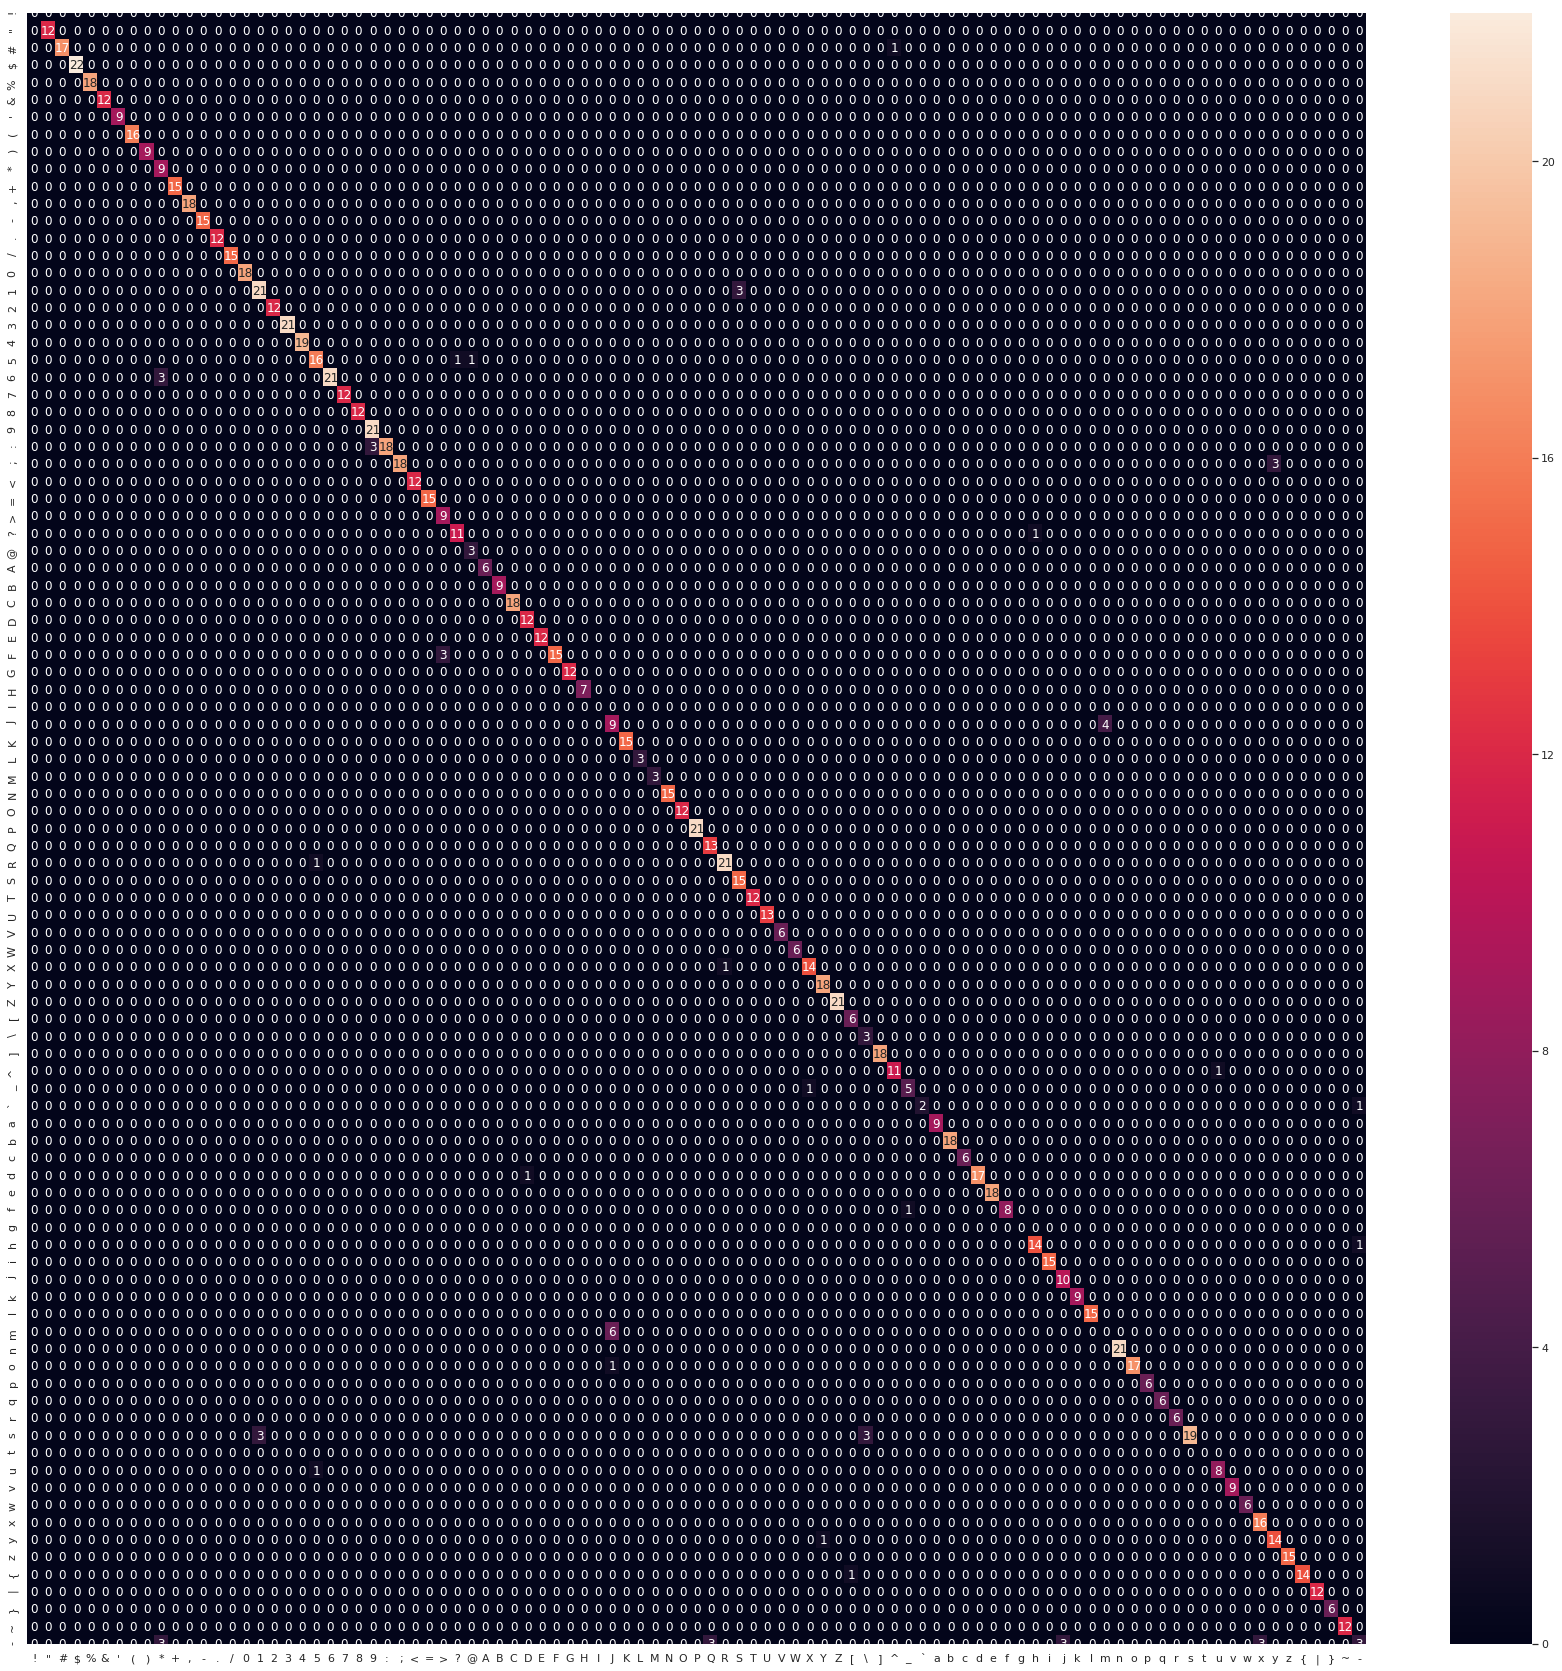

In [43]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# plot confusion matrix
confusion_matrix = np.zeros((len(alphapet)+1, len(alphapet)+1))
for c_p, c_t in zip(y_pred, y_targets):
    confusion_matrix[c_t, c_p] += 1
    
df = pd.DataFrame(confusion_matrix, index=[c for c in (alphapet+'-')], columns=[c for c in (alphapet+'-')])
plt.figure(figsize=(30,30))
sn.set(font_scale=1)
sn.heatmap(df, annot=True)

W=2+E1nTXrCaI


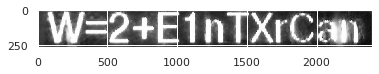

59gmJuxcX.d\


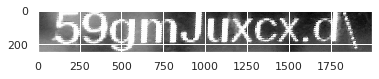

0c+bI"b6.Q-


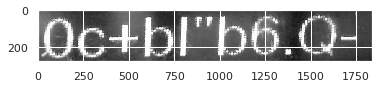

0c+bI"b6.Q-


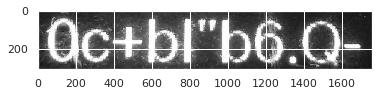

0c+bI"b6.Q-


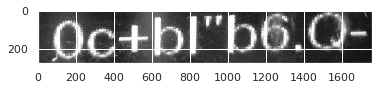

8KlZ5p$a}w,


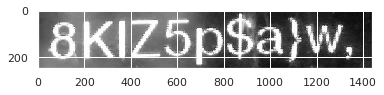

8KlZ5p$a}w,


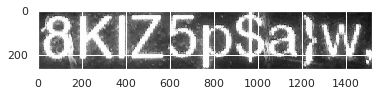

8KlZ5p$a}w,


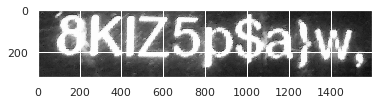

Z0"G/~$c1jt


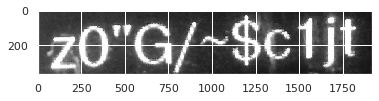

k$lFDeh]k0\X


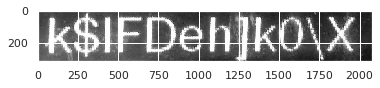

=0[x)R8iPw)


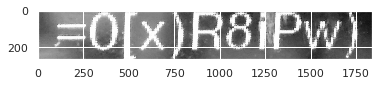

=0[x)R8iPw)


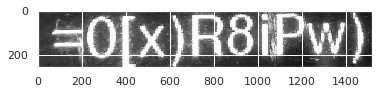

=0[x)R8iPw)


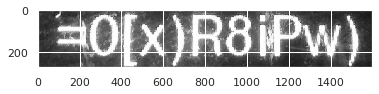

J;q+/zyU%U1x


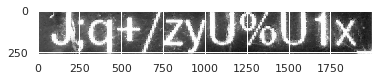

.COwu`u.R{3"#


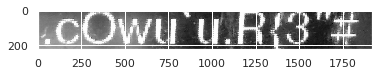

Q3gIz#Y:]q+*


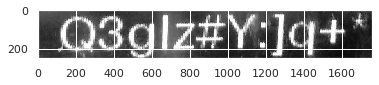

Q3gIz#Y:]q+*


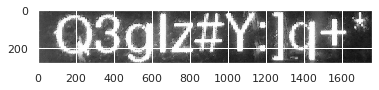

Q3gIz#Y:]q+*


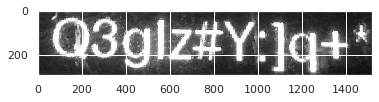

]t4?^WQ4>g


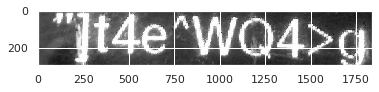

In [44]:
# display wrong samples\
for path, pred in zip(wrong_smaples, wrong_pred):
    print(pred)
    plt.imshow(np.array(Image.open(path).convert('L')), cmap='gray')
    plt.show()